In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [20]:
sns.set(rc={'figure.figsize': (9,6)})

In [4]:
events_data = pd.read_csv('data/event_data_train.csv')

In [5]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


Датасет который хранит действия всех юзеров на различных степах

Описание данных:

events_train.csv - данные о действиях, которые совершают студенты со стэпами

- step_id - id стэпа
- user_id - анонимизированный id юзера
- timestamp - время наступления события в формате unix date
- action - событие, возможные значения: 

- discovered - пользователь перешел на стэп
- viewed - просмотр шага,
- started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
- passed - удачное решение практического шага

submissions_train.csv - данные о времени и статусах сабмитов к практическим заданиям

- step_id - id стэпа
- timestamp - время отправки решения в формате unix date
- submission_status - статус решения
- user_id - анонимизированный id юзера

In [10]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

### Выполним базовую визуализацию

Переведем timestamp в привычный формат

In [9]:
events_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480703 entries, 0 to 3480702
Data columns (total 4 columns):
step_id      int64
timestamp    int64
action       object
user_id      int64
dtypes: int64(3), object(1)
memory usage: 106.2+ MB


Добавим столбец с преобразоваными данными

In [11]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [12]:
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [13]:
events_data.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
dtype: object

In [14]:
events_data.date.min()

Timestamp('2015-06-15 04:00:48')

Добавим столбец с конкретным днем

In [16]:
events_data['day'] = events_data.date.dt.date

In [17]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


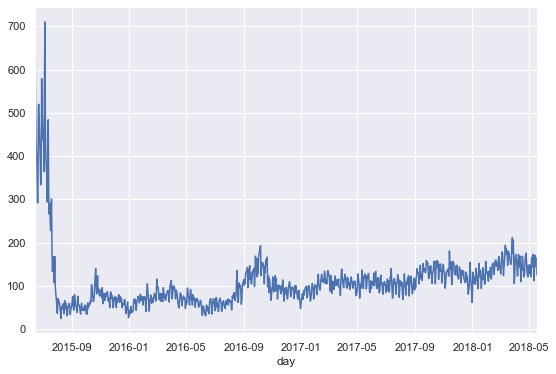

In [21]:
events_data.groupby('day') \
    .user_id.nunique().plot()

In [25]:
# events_data[events_data.action == 'passed'] \
#     .groupby('user_id', as_index=False) \
#     .agg({'step_id':'count'}) \
#     .rename(columns={'step_id':'passed_steps'}).passed_steps.hist()

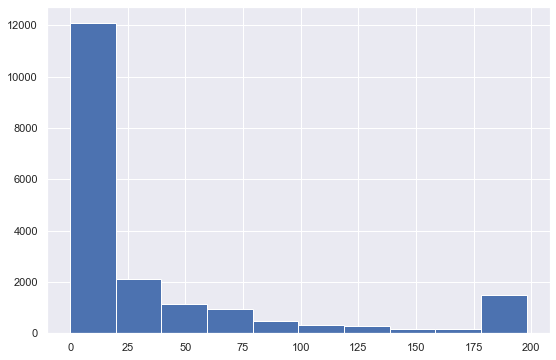

In [29]:
events_data.pivot_table(index='user_id',
                       columns='action',
                       values='step_id',
                       aggfunc='count',
                       fill_value=0).reset_index().discovered.hist()

Загрузим другой файл

In [31]:
submissions_data = pd.read_csv('data/submissions_data_train.csv')

In [32]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [33]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

In [34]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [36]:
users_scores = submissions_data.pivot_table(index='user_id',
                       columns='submission_status',
                       values='step_id',
                       aggfunc='count',
                       fill_value=0).reset_index()

In [37]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


Посмотрим на распределение средних перерывов между выполнением заданий

Отберем для каждого юзера дни когда он бля активен

In [47]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list).head() \
    .apply(np.diff).values

In [48]:
gap_df = pd.Series(np.concatenate(gap_data, axis=0))

In [59]:
hh= gap_df / (24 * 60 * 60)
hh.sort_values()

6      0.911019
3      1.084606
5      1.983796
2      2.112083
4     32.047106
0     56.060208
1     79.852419
7    390.078843
dtype: float64

In [65]:
users_scores.sort_values('correct', ascending=False)

submission_status,user_id,correct,wrong
439,1046,421,513
2099,5552,186,93
6415,17135,168,177
2344,6183,142,65
3208,8461,135,42
...,...,...,...
551,1321,0,2
9778,26349,0,1
3559,9422,0,1
5014,13408,0,2
